# Quora Views Prediction Challenge - Part III - EDA and Feature Engineering

In [32]:
import pandas as pd
import json
json_data = open('../views/sample/input00.in') # Edit this to where you have put the input00.in file

data = []
for line in json_data:
    data.append(json.loads(line))

data.remove(9000)
data.remove(1000)

df = pd.DataFrame(data)

df['anonymous'] = df['anonymous'].map({False: 0, True:1}).astype(int)
cleaned_df=df[:9000]

# to make reading the question_text cells easier, remove the maximum column width 
pd.set_option('display.max_colwidth', -1) 

In [33]:
from plotnine import *

---

## Missing `context_topic` 

At Quora, `context_topic` has been depreciated since 2015. It used to be the primary topic assigned to every new question. And this topic tag was not visible to viewers, so they didn't have a way to filter it out (**For this reason, I expect context_topic_followers to not contribute to view count.**).

Those with missing `context_topic`, which is the primary topic of the question. Although, as per the prompt, every question's `context_topic` json blob is said to be included in the topics array of each question, it is not. Let's investigate those with missing primary topics and try to derive some insight. 

In [100]:
df[['question_text', 'topics', 'context_topic']].head()

,question_text,topics,context_topic
0,What are some movies with mind boggling twists in it?,"[{'followers': 500022, 'name': 'Movies'}]","{'followers': 500022, 'name': 'Movies'}"
1,How do you prepare a 10 year old for International Mathematical Olympiad?,"[{'followers': 179, 'name': 'International Mathematical Olympiad (IMO)'}]","{'followers': 179, 'name': 'International Mathematical Olympiad (IMO)'}"
2,Why do bats sleep upside down?,"[{'followers': 614223, 'name': 'Science'}]","{'followers': 614223, 'name': 'Science'}"
3,Tell me everything about the Leidenfrost effect poetically?,"[{'followers': 614223, 'name': 'Science'}, {'followers': 28196, 'name': 'Poetry'}, {'followers': 7310, 'name': 'Survey Questions'}, {'followers': 100919, 'name': 'Life'}, {'followers': 278715, 'name': 'Literature'}]","{'followers': 614223, 'name': 'Science'}"
4,Is the Nexus 10 any good despite the dual core processor?,"[{'followers': 1536, 'name': 'Android Tablets'}]","{'followers': 1536, 'name': 'Android Tablets'}"



But we want to see the mean of `cleaned_df.__ans__` with the `ctm_w_ans` rows removed. So, let's make a column of a boolean feature of whether `context_topic` is missing or not and do an `np.mean` pivot table.

In [35]:
# make a copy of cleaned_df
data_df = cleaned_df.copy()

In [36]:
# create the column
data_df['context_present'] = data_df['context_topic'].apply(lambda x: 0 if x==None else 1)

Let's see what happens if we create a column out of the product of `num_answers` and `context_present`.

In [37]:
test = data_df['context_present'] * data_df['num_answers']

In [38]:
context_xnum = pd.DataFrame(test, columns=['context_xnum'])

In [39]:
test.corr(data_df.__ans__)

0.36215451128683945

#### New Feature: Product of `num_answers` and `context_present`

We see a moderate correlation with coefficient of `0.362` between the product `context_xnum` and `__ans__`. 

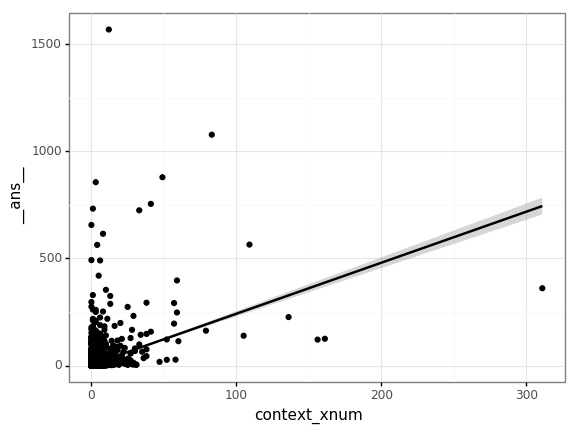

<ggplot: (8735782513405)>

In [40]:
(ggplot(pd.concat([data_df, context_xnum], axis=1), aes(x='context_xnum', y='__ans__')) + geom_point() + geom_smooth(method='lm') + theme_bw())

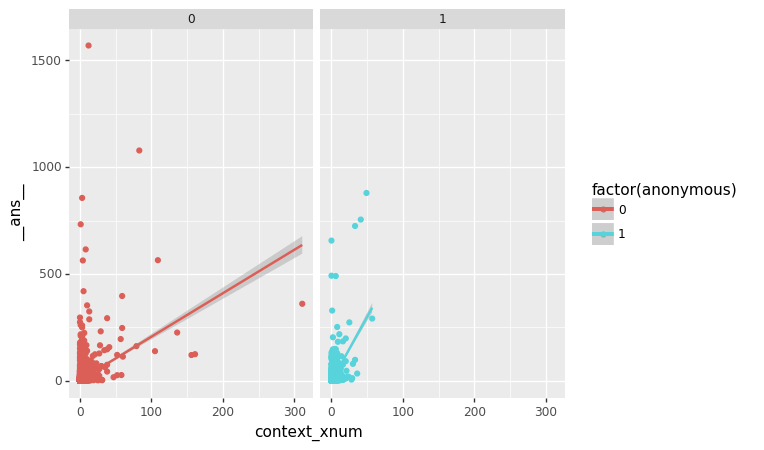

<ggplot: (8735782384420)>

In [41]:
(ggplot(pd.concat([data_df, context_xnum], axis=1), aes(x='context_xnum', y='__ans__', color='factor(anonymous)')) + 
 geom_point() + 
 stat_smooth( method='lm') + facet_wrap('~anonymous'))

**Surprisingly, those missing a context topic have a higher `__ans__` than those that do.** You would imagine the opposite assuming those missing a primary topic would be ones that are ignored or those that didn't garner enough attention. But quite the opposite seems to be true. 

In [99]:
data_df[data_df.context_present == 0][13:16]

,__ans__,anonymous,context_topic,num_answers,promoted_to,question_key,question_text,topics,context_present,len_question_text,qcontains_superlatives,qcontains_best_story,qcontains_best_liner
370,21.000000,0,None,0,0,AAEAAKuJkrLmqddpbRz8YB2hgNCAw/leTqxeX0R4kISOJ4ac,Is it possible to hurt your friendship with someone by introducing them to someone else who they later have a fallout with?,[],0,123,0,0,0
462,4.434483,0,None,2,0,AAEAAGhe4/URuDxoKUFg6o1mGf8x37Fz8vl+3VS7XhKTJL3n,What are few things which Indians don't know about Republic day?,[],0,64,0,0,0
492,29.000000,1,None,1,0,AAEAAHSYjMZ4m48TuQsWj1iY3W8tVuGiknpw9alNcVFKJG3J,What are the most stupid HR questions?,"[{'followers': 1689, 'name': 'Netaji Subhas Institute of Technology'}]",0,38,0,0,0


### How about `topics` column?

Another insight from the missing context_topic dataframe is that there are rows with missing `topics`. These went undetected last time because they are empty arrays and not `NaN` or missing values. 

In [43]:
topics_present = data_df['topics'].apply(lambda x: 0 if len(x) == 0 else 1)

In [44]:
topics_present.value_counts()

1    8979
0    21  
Name: topics, dtype: int64

In [45]:
topics_present.corr(data_df['__ans__'])

0.0026802819885979167

In [46]:
test_1 = topics_present * test # 0 if topics aren't present or num_answers = 0 or context_topic not present.

In [47]:
test_1.corr(data_df['__ans__'])

0.36215451128683945

The correlation hasn't changed, so at this point, we have nothing to do with the empty topics rows.

---

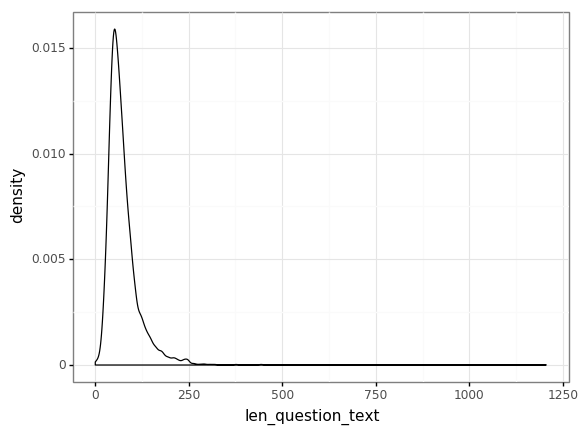

<ggplot: (8735788365309)>

In [48]:
# Short questionsb
data_df['len_question_text'] = data_df.question_text.apply(lambda x: len(x))

# plot
(ggplot(data_df, aes(x='len_question_text')) + geom_density() + theme_bw())

Let's look at questions with less than 10 characters. 

In [49]:
data_df[(data_df.len_question_text < 15)][['__ans__', 'question_text', 'len_question_text', 'num_answers']].sort_values(by="__ans__", ascending=False)

,__ans__,question_text,len_question_text,num_answers
1931,62.027027,Deleted,7,10
261,8.515152,Who are you?,12,7
2220,6.920354,What is 2 + 5?,14,9
6599,5.368421,Do,2,0
6208,4.765957,Deleted,7,0
179,4.179487,What is fiber?,14,2
5223,3.595238,DELETED,7,0
1208,2.611111,CANCELLED,9,0
3080,2.216216,h,1,1
7510,2.211268,@roous4393,10,0


In [149]:
#gives the correlation of `num_answers` to number of characters less than int_
def NumAnsCorrNumChar(int_): 
    question_shorter_than_int_=data_df['len_question_text'].apply(lambda x: 1 if x <= int_ else 0)
    return question_shorter_than_int_.corr(data_df['num_answers'])

#gives the correlation of `__ans__` to the product of num_answers and the ...
# ... boolean column of number of characters less than int_
def TargetCorrNumChar(int_): 
    question_shorter_than_int_=data_df['len_question_text'].apply(lambda x: 1 if x <= int_ else 0)
    prod = question_shorter_than_int_ * data_df['num_answers']
    return prod.corr(data_df['__ans__'])

In [159]:
some_list = []
for i in data_df['len_question_text'].values:
    some_list.append(NumAnsCorrNumChar(i))

In [160]:
min(some_list), max(some_list) #7 and 15 characters 

(-0.019433195945123764, 0.032976047487706384)

This is useless, did it out of curiousity. 

**How about the correlation between the number of characters and `__ans__`?**

In [151]:
some_list_1 = []
for i in data_df['len_question_text'].values:
    some_list_1.append(TargetCorrNumChar(i))

In [152]:
min(some_list_1), max(some_list_1) #7 and 15 characters 

(-0.003043560197922728, 0.3820463704019823)

In [153]:
some_list_1.index(0.3820463704019823) #the index of the max

141

In [155]:
data_df.iloc[141]['len_question_text'] # the number of characters 

182

* The feature deciding whether a question is less than 182 characters long (valued 1) or shorter has a moderate correlation with the target column `__ans__`. 

---

Observe that most of the questions in the bottom of the list have no question marks; so, let's explore that.

In [56]:
data_df[(~data_df.question_text.str.contains("[?]"))][['__ans__', 'question_text', 'num_answers']].sort_values(by="__ans__", ascending=False).head()

,__ans__,question_text,num_answers
1931,62.027027,Deleted,10
4463,8.348837,IOS in-App purchases for timed in-game lives,1
4329,7.837209,I have developed a 40$ product that transforms an existing power outlet and switches in home into Smartphone controlled smart switches,4
3348,6.245902,Show that the conditions for spontaneity of a process occurring in a closed system involving only expansion work : change of Gibbs free energy at constant temperature and pressure is less than zero.,0
4550,6.166667,How to sync instagram with path,0


In [57]:
q_df = data_df.question_text.apply(lambda x: 1 if ( (any(~pd.Series(x).str.contains('[?]')))) else 0)

In [58]:
q_df.corr(data_df.__ans__)

-0.013093447660023082

Nothing significant!

## Correlation between `__ans__` and certain keywords

Let me start by clarifying the title of this section. I want to investigate if the appearance of certain words in the `question_text` affect views (`__ans__` and technically the ratio views to age, but I will just call it views). Also, when I write "the correlation of some word," I am referring to the correlation of `__ans__` to a boolean column corresponding to whether the question text in that row contains this word.

---

#### Correlation Calculators for Keyword Combinations

To make our lives easier, let's automate the process.

In [59]:
# Combination checker function `ccc=checkCorrComb`
def CorrOR(str_):
    split = str_.split(', ')
    joined= '|'.join(split)
    # create a pd series with boolean values 
    combined_df = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(joined))) else 0)
    return combined_df.corr(data_df.__ans__)

def CorrAND(str_):
    split = str_.split(', ')
    # create a pd series with boolean values 
    combined_df = data_df.question_text.apply(lambda x: 1 if all(words in x for words in split) else 0)
    return combined_df.corr(data_df.__ans__)

#Since Quora has a huge userbase in India and Pakistan, let's start there
CorrOR('Pakistan, Pakistani, India, Indian, IIT, Delhi, Modi'), CorrAND('India, Pakistan')

(0.048178865447050856, 0.013902202526612993)

In [60]:
combination_test_1 = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains('Pakistan|Pakistani|India|Indian|IIT|Delhi|Modi')) else 0)
combination_test_2 = data_df.question_text.apply(lambda x: 1 if all(words in x for words in ['India', 'Pakistan']) else 0)
combination_test_1.corr(data_df.__ans__), combination_test_2.corr(data_df.__ans__)

(0.048178865447050856, 0.013902202526612993)

Ok, the functions work well!

---

### Keywords: Superlative Adjectives

Ok let's create another question_text filter.

In [61]:
# Superlatives 
sup_list = ['angriest', 'worst', 'biggest', 'bitterest', 'blackest', 'blandest', 'bloodiest', 'bluest', 'boldest', 'bossiest', 'bravest', 'briefest', 'brightest', 'broadest', 'busiest', 'calmest', 'cheapest', 'chewiest', 'chubbiest', 'classiest', 'cleanest', 'clearest', 'cleverest', 'closest', 'cloudiest', 'clumsiest', 'coarsest', 'coldest', 'coolest', 'craziest', 'creamiest', 'creepiest', 'crispiest', 'cruellest', 'crunchiest', 'curliest', 'curviest', 'cutest', 'dampest', 'darkest', 'deadliest', 'deepest', 'densest', 'dirtiest', 'driest', 'dullest', 'dumbest', 'dustiest', 'earliest', 'easiest', 'faintest', 'fairest', 'fanciest', 'furthest/farthest', 'fastest', 'fattest', 'fewest', 'fiercest', 'filthiest', 'finest', 'firmest', 'fittest', 'flakiest', 'flattest', 'freshest', 'friendliest', 'fullest', 'funniest', 'gentlest', 'gloomiest', 'best', 'grandest', 'gravest', 'greasiest', 'greatest', 'greediest', 'grossest', 'guiltiest', 'hairiest', 'handiest', 'happiest', 'hardest', 'harshest', 'healthiest', 'heaviest', 'highest', 'hippest', 'hottest', 'humblest', 'hungriest', 'iciest', 'itchiest', 'juiciest', 'kindest', 'largest', 'latest', 'laziest', 'lightest', 'likeliest', 'littlest', 'liveliest', 'loneliest', 'longest', 'loudest', 'loveliest', 'lowest', 'maddest', 'meanest', 'messiest', 'mildest', 'moistest', 'narrowest', 'nastiest', 'naughtiest', 'nearest', 'neatest', 'neediest', 'newest', 'nicest', 'noisiest', 'oddest', 'oiliest', 'oldest/eldest', 'plainest', 'politest', 'poorest', 'prettiest', 'proudest', 'purest', 'quickest', 'quietest', 'rarest', 'rawest', 'richest', 'ripest', 'riskiest', 'roomiest', 'roughest', 'rudest', 'rustiest', 'saddest', 'safest', 'saltiest', 'sanest', 'scariest', 'shallowest', 'sharpest', 'shiniest', 'shortest', 'shyest', 'silliest', 'simplest', 'sincerest', 'skinniest', 'sleepiest', 'slimmest', 'slimiest', 'slowest', 'smallest', 'smartest', 'smelliest', 'smokiest', 'smoothest', 'softest', 'soonest', 'sorest', 'sorriest', 'sourest', 'spiciest', 'steepest', 'stingiest', 'strangest', 'strictest', 'strongest', 'sunniest', 'sweatiest', 'sweetest', 'tallest', 'tannest', 'tastiest', 'thickest', 'thinnest', 'thirstiest', 'tiniest', 'toughest', 'truest', 'ugliest', 'warmest', 'weakest', 'wealthiest', 'weirdest', 'wettest', 'widest', 'wildest', 'windiest', 'wisest', 'worldliest', 'worthiest', 'youngest']
data_df['qcontains_superlatives'] = data_df.question_text.apply(lambda x: 1 if any(st in x for st in sup_list) else 0)

In [62]:
data_df['qcontains_superlatives'].corr(data_df['__ans__'])

-0.001720050755521242

Ok, not as promising as I thought! Let's go through the list and look for the best one.

### Keywords: "Best" et al.

In [66]:
# questions containing best, most, or epic
CorrOR('best, most, epic')

0.017637761989366695

Not as I expected. What if I multiply it by the number of answers?

#### Feature Expander

In [67]:
# Calculates the correlation between [a boolean column of question texts containing `str_` multiplied by num_answers] and [num_answers]
# eg. CorrORxNumAns('cat, dog, book, animals')
def CorrORxNumAns(str_):
    split = str_.split(', ')
    joined= '|'.join(split)
    combined_df = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(joined))) else 0)
    xnum_combined_df = combined_df * data_df['num_answers']
    return xnum_combined_df.corr(data_df.__ans__)

In [68]:
CorrORxNumAns('best, most, epic, university, stories')

0.26459143217330872

Let's check if it matters that the number of answers is greater than 1 (as opposed to just 0 or 1, for all with at least one answer). So lets do the following:

In [69]:
# make a class of questions with answers >= 1
a=pd.DataFrame()
a['num_answers_g0'] = data_df['num_answers'].apply(lambda x: 1 if x != 0 else 0)

In [70]:
# multiply `qcontains_best` by the number of answers>=1
a['qcontains_best'] = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str('best|most|epic|India|'))) else 0)
b = a['qcontains_best'] * a['num_answers_g0']
b.corr(data_df['__ans__'])

0.086570497404718158

So, it does matter that some questions have more number of answers than others. 

---

### Exploring `num_answers`

Let's begin with a simple historgram.

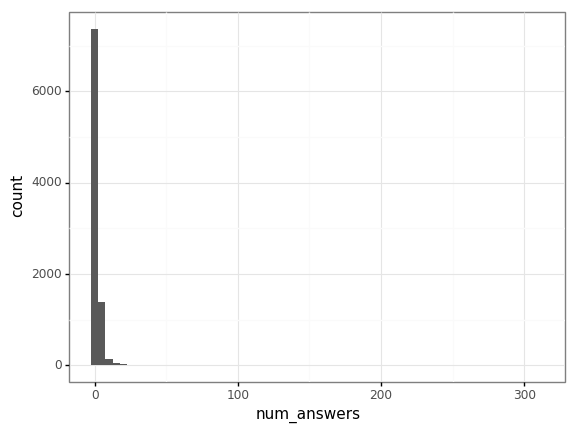

<ggplot: (8735782492157)>

In [71]:
(ggplot(data_df, aes(x="num_answers")) +\
    geom_histogram(binwidth = 5)
    + theme_bw())

How about questions with more than 6 answers?

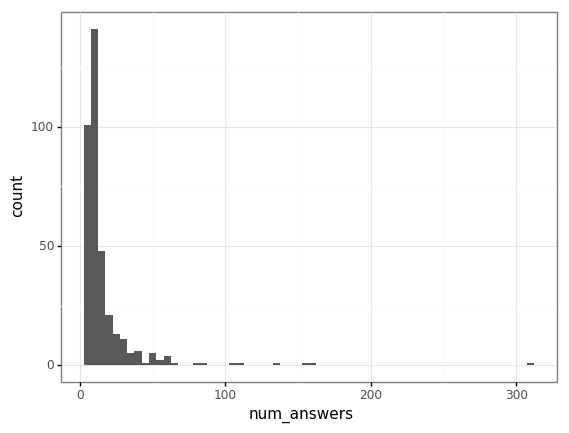

<ggplot: (8735787992647)>

In [75]:
(ggplot(data_df[data_df.num_answers > 6], aes(x="num_answers")) +\
    geom_histogram(binwidth = 5) + theme_bw())

Ok, let's see the scatter plot of `num_answers` and `__ans__` (dependent variable). 

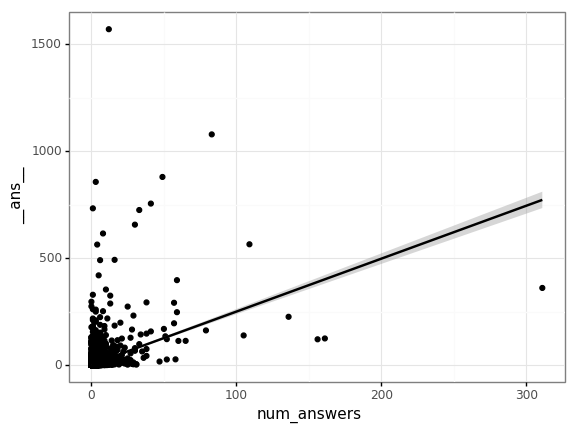

<ggplot: (-9223363301066681519)>

In [76]:
(ggplot(data_df, aes(x="num_answers", y="__ans__")) 
    + geom_point()
    + geom_smooth(method='lm')
    + theme_bw())

In [77]:
print('The correlation above is {}.'.format(data_df['num_answers'].corr(data_df['__ans__'])))

The correlation above is 0.3817680880491783.


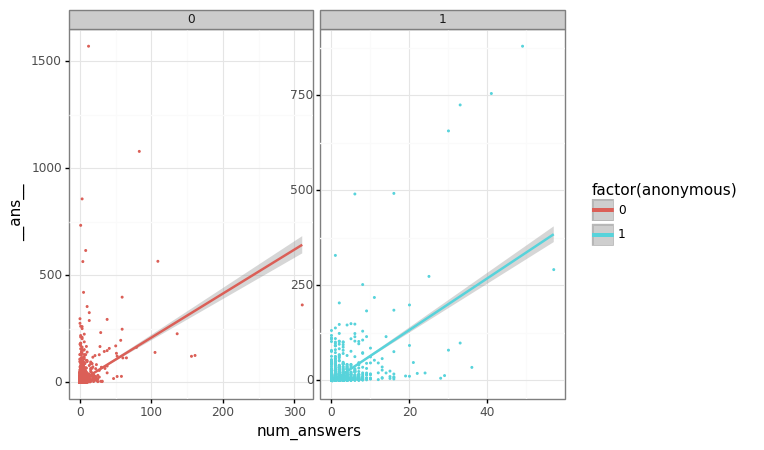

<ggplot: (-9223363301066741802)>

In [78]:
(ggplot(data_df, aes('num_answers', '__ans__', color='factor(anonymous)'))
 + theme_bw() #black and white theme
 + geom_point(size=0.2) 
 + geom_smooth(aes(color='factor(anonymous)'), method='lm') 
 + facet_wrap('~anonymous', nrow=1, scales='free')) # divide the plot by the 'anonymous' column

In [79]:
print('For the 0 plot, the coefficient of correlation is {0}, whereas for the 1 plot, it is {1}.'.format(data_df[data_df['anonymous']==0]['num_answers'].corr(data_df[data_df['anonymous']==0]['__ans__']), data_df[data_df['anonymous']==1]['num_answers'].corr(data_df[data_df['anonymous']==1]['__ans__'])))

For the 0 plot, the coefficient of correlation is 0.36274722384854935, whereas for the 1 plot, it is 0.5674038710053823.


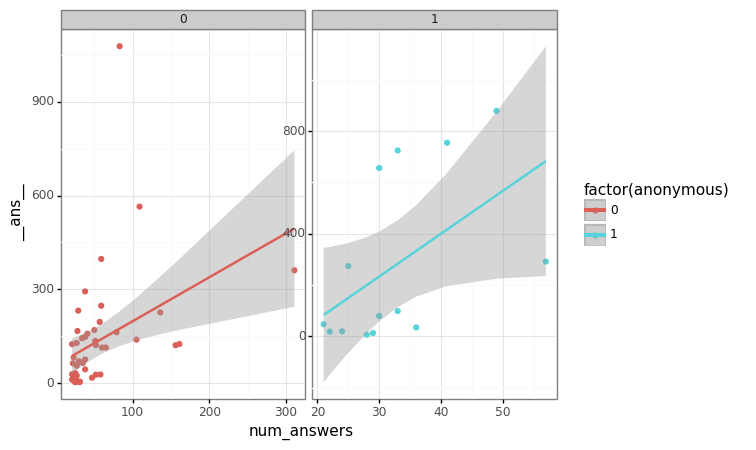

<ggplot: (8735782320427)>

In [80]:
(ggplot(data_df[data_df.num_answers > 20], aes('num_answers', '__ans__', color='factor(anonymous)'))
 + theme(legend_position="left")
 + geom_point() 
 + geom_smooth(aes(color='factor(anonymous)'), method='lm') 
 + facet_wrap('~anonymous', nrow=1, scales='free')
 + theme_bw())

This begs the question: which `num_answers` maximizes the correlation. 

In [81]:
def Corr_gNumAns(int_):
    # create a pd series with boolean values 
    combined_df = data_df.num_answers.apply(lambda x: 1 if x > int_ else 0)
    return combined_df.corr(data_df.__ans__)

In [82]:
Corr_gNumAns(0)

0.086570497404718158

In [83]:
s_df = pd.DataFrame()
s_df['>=num_ans'] = data_df.num_answers
s = data_df.num_answers.values

In [84]:
# calculate correlation
cor = []
for i in range(len(s)):
    cor.append(Corr_gNumAns(i))

In [85]:
# calculate correlation
cor = []
for i in s:
    cor.append(Corr_gNumAns(i))

In [86]:
cor_df = pd.DataFrame(cor, columns=['cor_coef'])
cor_df.tail()

,cor_coef
8995,0.086570
8996,0.086570
8997,0.144580
8998,0.086570
8999,0.189539


Since we have quite a few `NaN`, we will only plot the non-`NaN` ones.

In [87]:
num_corcoef_df = pd.concat([s_df, cor_df, data_df['anonymous'], data_df['__ans__']], axis=1)

In [98]:
num_corcoef_df.head()

,>=num_ans,cor_coef,anonymous,__ans__
0,4.0,0.245913,0.0,2.089474
1,1.0,0.144580,0.0,2.692308
2,1.0,0.144580,0.0,4.612903
3,1.0,0.144580,0.0,8.051948
4,0.0,0.086570,0.0,0.150943


In [89]:
num_corcoef_df.iloc[2451]

>=num_ans    311.000000
cor_coef    NaN        
anonymous    0.000000  
__ans__      360.827027
Name: 2451, dtype: float64

In [90]:
num_corcoef_df.iloc[2451] = num_corcoef_df.iloc[2452]

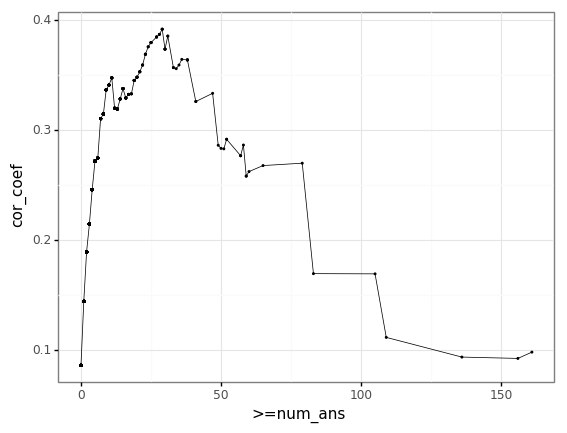

<ggplot: (-9223363301072564343)>

In [91]:
(ggplot(num_corcoef_df, aes('>=num_ans', 'cor_coef', size='__ans__'))
    + geom_point(size=0.2)
    + geom_line(size=0.3)
    + theme_bw())

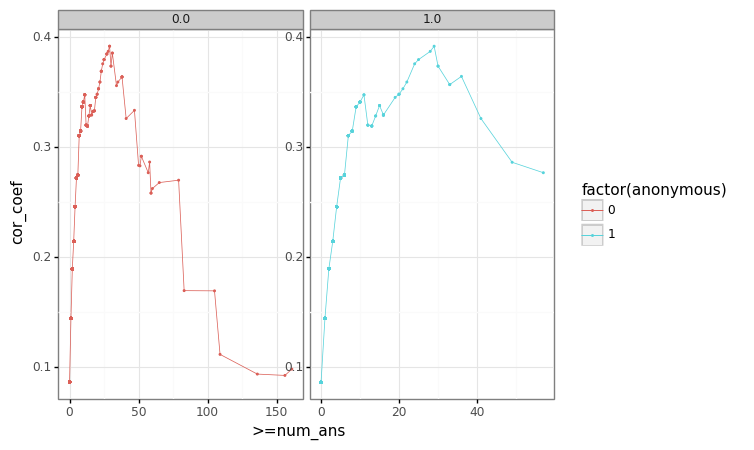

<ggplot: (8735782230634)>

In [92]:
(ggplot(num_corcoef_df, aes('>=num_ans', 'cor_coef', size='__ans__', color='factor(anonymous)'))
    + geom_point(size=0.2)
    + geom_line(size=0.3)
    + theme_bw()
    + facet_wrap('~anonymous', scales='free'))

So where is the absolute max of `cor_coef` achieved? 

In [93]:
num_corcoef_df.iloc[list(num_corcoef_df.cor_coef.values).index(max(list(num_corcoef_df.cor_coef.values)))] # there is probably a non-gory way of doing this

>=num_ans    29.000000
cor_coef     0.391563 
anonymous    1.000000 
__ans__      12.921053
Name: 936, dtype: float64

This tells us that setting a boolean column of whether the number of answers is more than 29 gives us a feature that has a correlation coefficient of 0.39 with our target label `__ans__`.

#### New Feature: Questions with at least 29 Answers

In [105]:
data_df['num_ans>= 29'] = data_df['num_answers'].apply(lambda x: 1 if x>=29 else 0)

In [107]:
data_df['num_ans>= 29'].describe()

count    9000.000000
mean     0.004556   
std      0.067345   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      1.000000   
Name: num_ans>= 29, dtype: float64

In [108]:
data_df['num_ans>= 29'].corr(data_df['__ans__'])

0.38688133081043052

---

### Only "stories"

What about stories? One common theme I see among popular questions in Quora is questions about the best stories or one liners, etc. Let's see if questions with these terms have a more significant correlation than features we built earlier. 

In [110]:
data_df[data_df.question_text.str.contains(' story|Story|stories|Stories')][['question_text', '__ans__']].describe() # the space before story is in order to avoid mixing up of history

,__ans__
count,54.000000
mean,18.190973
std,35.926279
min,0.184375
25%,0.901786
50%,2.144773
75%,9.923735
max,181.000000


There are 54 of these.

In [111]:
# Best stories
data_df['qcontains_best_story'] = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(" story|Story|stories|Stories")) else 0)

In [112]:
# do a correlation
data_df['qcontains_best_story'].corr(data_df['__ans__'])

0.021451384574100143

But it's not promising.

In [113]:
# Best one-liner
# first let's get a hint of the keywords associated with "liners"
data_df['qcontains_best_liner'] = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains("liners")) else 0)
print(data_df['qcontains_best_liner'].corr(data_df['__ans__']))

data_df[data_df.question_text.str.contains('liners')][['question_text', '__ans__']]

0.0639145893658


,question_text,__ans__
2451,What are some interesting one liners on India?,360.827027
4521,What are your favourite one-liners from Friends (TV Series)?,32.054054
6924,"What would be good one-liners to complete the phrase, ""There are two kinds of people, those who ...""?",27.314607


It wasn't a bad observation afterall, even though I am surprised at the fewness of the questions about one-liners. That probably explains why the correlation is quite low. 

---

**We will continue exploring keywords in the next notebook!**